In [135]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 1. Loading data

Loading two datasets namely "yelp_business" and "yelp_review"

In [136]:
original_business_df = pd.read_csv("yelp_business.csv")

In [137]:
original_business_df.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [138]:
original_reviews_df = pd.read_csv("yelp_review.csv", nrows=1000000)

In [139]:
original_reviews_df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


# 2. Data cleaning
To get the best results, we are cleaning up the `text` column of the reviews dataset to get rid of non-alphabetic characters.

In [140]:
# Filtering unused columns
business_columns_to_keep = ['business_id', 'name', 'city', 'state', 'latitude', 'longitude', 'review_count']
business_df = business_df[business_columns_to_keep]
business_df.head()

,business_id,name,city,state,latitude,longitude,review_count
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,AZ,33.330690,-111.978599,22
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",McMurray,PA,40.291685,-80.104900,11
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",Phoenix,AZ,33.524903,-112.115310,18
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",Tempe,AZ,33.383147,-111.964725,9
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",Cuyahoga Falls,OH,41.119535,-81.475690,116


In [141]:
# Filtering unused columns
reviews_columns_to_keep = ['review_id', 'user_id', 'business_id', 'stars', 'date', 'text']
new_reviews_df = reviews_df[reviews_columns_to_keep]
new_reviews_df.head()

,review_id,user_id,business_id,stars,date,text
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...


In [142]:
# Removing Null values
print(business_df.shape, reviews_df.shape)
business_df = business_df.dropna() # Drops all rows that contain null values
reviews_df = reviews_df.dropna()
print(business_df.shape, reviews_df.shape)

(174564, 7) (1000000, 6)
(174564, 7) (1000000, 6)


In [143]:
# Merging two datasets

business_reviews_df = pd.merge(business_df, reviews_df, on='business_id', how='inner')
business_reviews_df.shape

(999988, 12)

In [144]:
business_reviews_df.head()

,business_id,name,city,state,latitude,longitude,review_count,review_id,user_id,stars,date,text
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,AZ,33.33069,-111.978599,22,3_-fne2m2GvKESZRlULAiw,jTvKkNTat9QftSxL_FMcQw,5,2017-02-22,"They make a plan, for your mouth to get health..."
1,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,AZ,33.33069,-111.978599,22,5gJk64TDq5lqSuoNiaqjVQ,IG6XMgQyWF2_RW1nKEioxA,5,2015-01-20,I have extreme anxiety when it comes to the de...
2,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,AZ,33.33069,-111.978599,22,5570rwX_o30Z3NmKhou4CQ,2Rh41EBjWI137N2m5VHJJA,5,2013-06-06,I've only been here once but my husband has be...
3,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,AZ,33.33069,-111.978599,22,iRm438GDAajUiW2GoIAvtA,YcmNpPM0ag94g4T0zAtdcg,4,2016-05-07,Great experience with the hygenists and pediat...
4,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",Ahwatukee,AZ,33.33069,-111.978599,22,9lhJwhRwTsqqPyyoSjMuqw,XGL7VDkeUyM5nKQspJBTNw,5,2014-04-13,My husband and I went to this dentist as a rec...


In [145]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text) 
    return text

business_reviews_df['cleaned_text'] = business_reviews_df['text'].apply(clean_text)

# 3. Overview of Data

In [146]:
business_reviews_df.describe()

,latitude,longitude,review_count,stars
count,999988.000000,999988.000000,999988.000000,999988.000000
mean,37.285967,-100.954109,352.215828,3.730457
std,4.307939,20.667366,738.228391,1.439177
min,-36.086009,-142.466650,3.000000,1.000000
25%,33.609078,-115.154332,33.000000,3.000000
50%,36.107183,-111.965225,108.000000,4.000000
75%,40.445146,-80.861432,328.000000,5.000000
max,89.999314,115.086769,7361.000000,5.000000


In [147]:
print('unique reviews in the dataset --->', business_reviews_df['review_id'].nunique())
print('unique users in the dataset --->', business_reviews_df['user_id'].nunique())
print('unique businesses in the dataset --->', business_reviews_df['business_id'].nunique())

unique reviews in the dataset ---> 999988
unique users in the dataset ---> 259417
unique businesses in the dataset ---> 136029


# 4. Data pre-processing
We are setting up the sentiment boundaries. Anything below 3 star is classified as negative and given value 0 and any reviews with 4 stars or more is classified as positive and given value 1. Anything in between is classified as None.

In summary:
- Stars >= 4: 1 - Positive review
- Starts <= 2: 0 - Negative review
- Else: None

Finally, all the reviews with above None values are removed as this is irrelevant in our further analysis.

In [148]:
business_reviews_df['sentiment'] = business_reviews_df['stars'].apply(lambda x: 0 if x <= 2 else (1 if x >= 4 else None))
business_reviews_df = business_reviews_df.dropna(subset=['sentiment'])

# 5. Model training
Now a regression model is trained on the above data. The data is vectorized with TF-IDF vectorized before it is fed to the model for training.

In [149]:
X = business_reviews_df['cleaned_text']
y = business_reviews_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000, random_state=111)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=111)

# 6. Model evaluation
Once the model is trained, we have to evaluate the performance. 

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90     44748
         1.0       0.96      0.97      0.97    132440

    accuracy                           0.95    177188
   macro avg       0.94      0.93      0.93    177188
weighted avg       0.95      0.95      0.95    177188



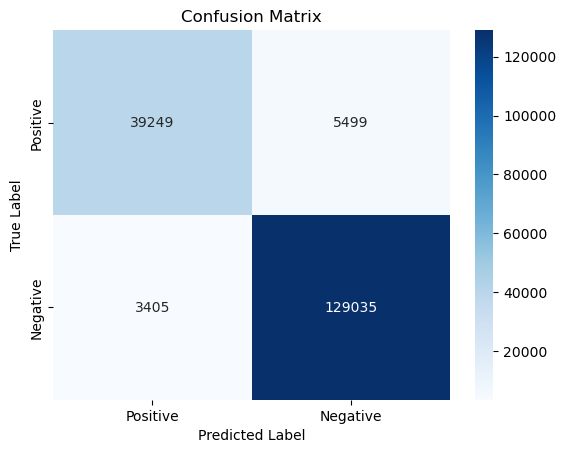

In [150]:
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The model manages to produce a good accuracy score of 95%

### Results
Now we have the predictions, we can have a quick look the most features 50 keywords in both positive and negative reviews.

Top 50 Positive Keywords:
[('heaven', 5.460191328660198), ('courteous', 5.464321974155173), ('reasonably', 5.466885298145271), ('comfortable', 5.697887221645295), ('yum', 5.759060941531236), ('tasty', 5.773673555716267), ('exceptional', 5.790993258035639), ('delish', 5.839751690055448), ('happy', 5.969201567168767), ('affordable', 5.976881994662416), ('bomb', 6.0113052116576835), ('solid', 6.041741594117374), ('helped', 6.094143388193723), ('fabulous', 6.254273443477772), ('gem', 6.335956497330142), ('satisfied', 6.352402480229768), ('easy', 6.422276329146937), ('beat', 6.544302989992371), ('phenomenal', 6.722341605238829), ('pleasantly', 6.741184170689051), ('perfection', 7.000186381178274), ('good', 7.070753973938703), ('friendly', 7.0772594584360755), ('knowledgeable', 7.088901068461931), ('professional', 7.30240851077095), ('notch', 7.381726958698028), ('reasonable', 7.4329796682431155), ('pleased', 7.481000734601213), ('glad', 7.507076958112704), ('yummy', 7.630342428033158), ('he

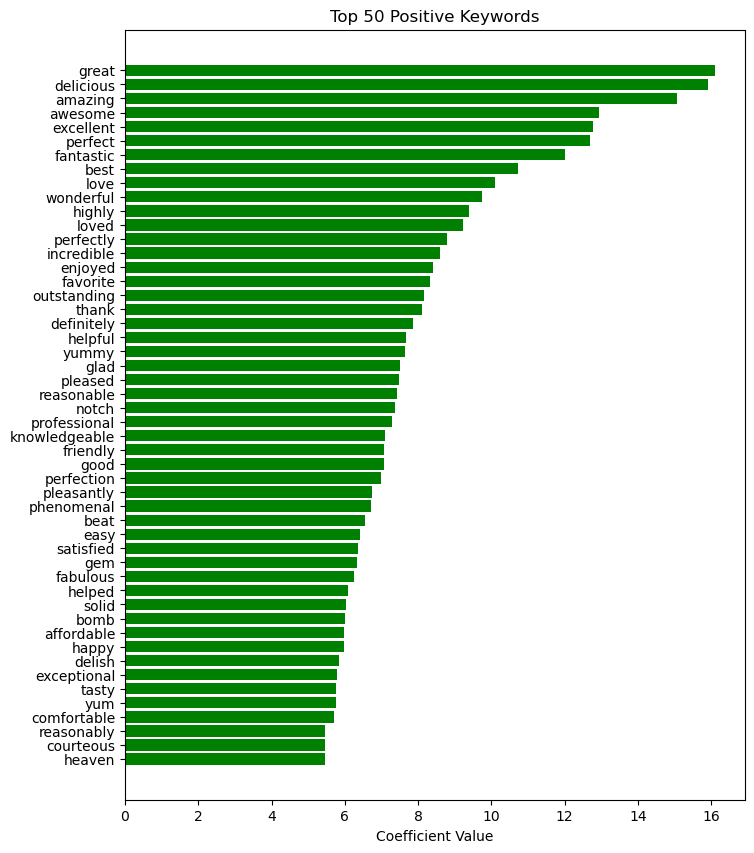

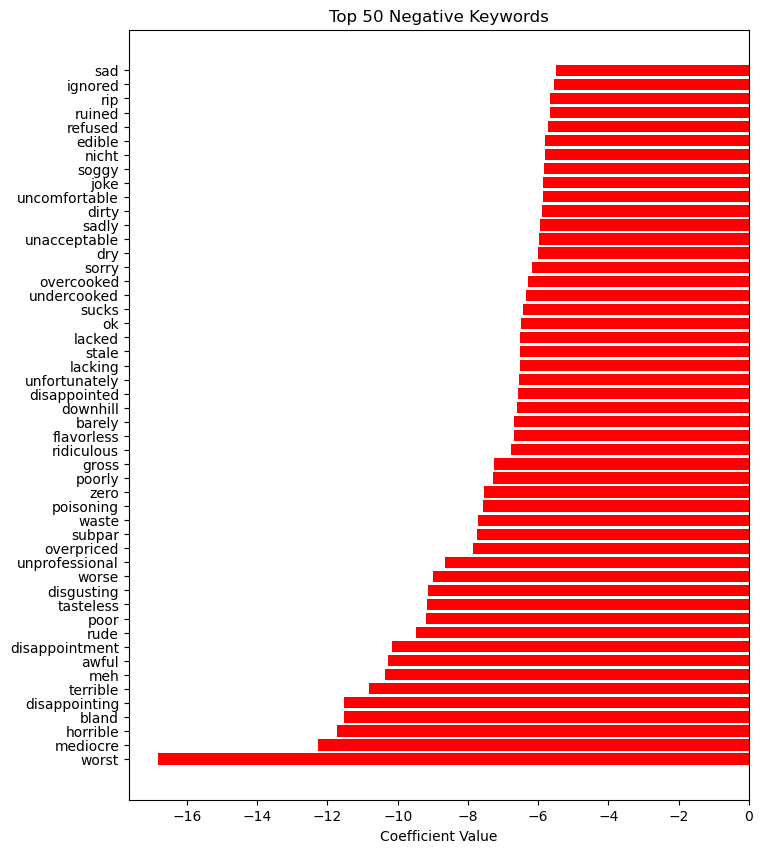

In [151]:
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
coefficients = model.coef_[0]

positive_indices = np.argsort(coefficients)[-50:]
negative_indices = np.argsort(coefficients)[:50] 

top_positive_keywords = feature_names[positive_indices]
top_negative_keywords = feature_names[negative_indices]

positive_scores = coefficients[positive_indices]
negative_scores = coefficients[negative_indices]

print("Top 50 Positive Keywords:")
print(list(zip(top_positive_keywords, positive_scores)))

print("\nTop 50 Negative Keywords:")
print(list(zip(top_negative_keywords, negative_scores)))

plt.figure(figsize=(8, 10))
plt.barh(top_positive_keywords, positive_scores, color='green')
plt.xlabel('Coefficient Value')
plt.title('Top 50 Positive Keywords')
plt.show()


plt.figure(figsize=(8, 10))
plt.barh(top_negative_keywords, negative_scores, color='red')
plt.xlabel('Coefficient Value')
plt.title('Top 50 Negative Keywords')
plt.show()


# 7. USECASE

Lets take Top Ten Best Reviewed Business in Toronto.

We list the Top Ten business in Toronto giving importance to the number of reviews and then to the number of stars obtained by the business.

In [152]:
# Filtering toronto city
toronto_business_reviews = original_business_df[original_business_df["city"] == "Toronto"]

# Sort by 'review_count' and 'stars' in descending order
toronto_business_reviews = toronto_business_reviews.sort_values(by=["review_count", "stars"], ascending=[False, False])

toronto_business_reviews = sorted_df.head(10)

# Get the top 10 best review businesses
toronto_business_reviews.head(10)

,business_id,name,city,state,latitude,longitude,review_count,stars
10921,r_BrIgzYcwo1NAuG9dLbpg,"""Pai Northern Thai Kitchen""",Toronto,ON,43.647866,-79.388642,1494,5
7580,aLcFhMe6DDJ430zelCpd2A,"""Khao San Road""",Toronto,ON,43.646411,-79.393480,1270,5
5654,RtUvSWO_UZ8V3Wpj0n077w,"""KINKA IZAKAYA ORIGINAL""",Toronto,ON,43.660524,-79.378927,1184,5
4745,N93EYZy9R0sdlEvubu94ig,"""Banh Mi Boys""",Toronto,ON,43.648827,-79.396970,973,5
9158,iGEvDk6hsizigmXhDKs2Vg,"""Seven Lives Tacos Y Mariscos""",Toronto,ON,43.654341,-79.400480,945,5
5658,RwRNR4z3kY-4OsFqigY5sw,"""Uncle Tetsu's Japanese Cheesecake""",Toronto,ON,43.655969,-79.384013,848,5
130,-av1lZI1JDY_RZN2eTMnWg,"""Salad King Restaurant""",Toronto,ON,43.657648,-79.381728,808,5
12558,zgQHtqX0gqMw1nlBZl2VnQ,"""Momofuku Noodle Bar""",Toronto,ON,43.649678,-79.386275,759,5
11437,uAAWlLdsoUf872F1FKiX1A,"""Bang Bang Ice Cream and bakery""",Toronto,ON,43.646286,-79.419474,746,5
8548,f5O7v_X_jCg2itqacRfxhg,"""Sansotei Ramen""",Toronto,ON,43.655004,-79.386473,701,5


# 8. Topic Modelling

Lets take the first "Pai Northern Thai Kitchen" in top best review business

In [153]:
# Deep learning
import tensorflow_hub as hub

# Hugging Face
from transformers import pipeline

# Scikit-learn
from sklearn.cluster import KMeans

# NLP
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

In [154]:
# Download some nltk required data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aakas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aakas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [155]:
# Universal sentence encoder (from Google)
USE_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Function to use USE encoder
def embed(input):
    return np.array(USE_encoder(input))

In [156]:
# Get sentiment model from hugging face platform

sentiment_model = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [157]:
def sentiment(input):
    result = sentiment_model(input[:512])
    sign = 1 if(result[0]['label']=="POSITIVE") else -1
    value = result[0]['score']
    return sign*value

In [158]:
reviews_df.shape

(1000000, 6)

In [159]:
pai_thai_reviews = business_reviews_df[business_reviews_df['business_id'] == 'r_BrIgzYcwo1NAuG9dLbpg']['text'].dropna().tolist()
len(pai_thai_reviews)

284

In [160]:
class ReviewsTopicModel:

    STOPWORDS = stopwords.words('english') # stopwords from ntlk

    EMBEDDING_DIM = 512 # USE encoder

    # Constructor
    def __init__(self, reviews):
        self.X = self.clean(reviews)

    # Clean text method
    def clean(self, reviews):
        # Words to replace
        string_map = {'\r': '', '\n': '', '/': ' ', "'": "", '"': ''}
        reviews_cleaned = reviews[:]
        for i in range(len(reviews_cleaned)):
            for s in string_map:
                reviews_cleaned[i] = reviews_cleaned[i].replace(s, string_map[s]).lower() 
        # Transform the reviews into embeddings dataframe
        X = embed(reviews_cleaned)
        X = pd.DataFrame(X)
        X.index = reviews_cleaned
        return X

    # Method to determine number of topics (a.k.a kmeans cluster number)
    def elbow_plot(self):
        cluster_sizes = list(range(1, 81))
        cluster_scores = []
        for n in cluster_sizes:
            kmeans = KMeans(n_clusters=n)
            kmeans.fit(self.X)
            cluster_scores.append(kmeans.inertia_)
        plt.figure()
        plt.plot(cluster_sizes, cluster_scores)
        plt.show()

    # Method to extract topics from text data
    def create_topics(self, num_topics):
        # Cluster the reviews
        kmeans = KMeans(n_clusters=num_topics)
        kmeans.fit(self.X)

        # Create the final topics dataframe
        topics_df = self.X.copy()
        topics_df['topic'] = kmeans.labels_.copy()
        topics_df['topic'] = topics_df['topic'].astype(int)

        # Create summary keywords per topic
        topic_keywords = {}
        for topic in topics_df['topic'].unique():
            topic_reviews = topics_df.query("topic == {}".format(topic)).index.tolist()
            topic_centroid = kmeans.cluster_centers_[topic] # cluster center
            topic_keywords[topic] = self.get_closest_words(topic_reviews, topic_centroid)
        topics_df['topic_keywords'] = topics_df['topic'].map(topic_keywords)

        # Score the sentiment of each review
        topics_df['sentiment'] = [sentiment(r) for r in topics_df.index.values.tolist()]

        # Final result
        self.topics_keywords = topic_keywords
        self.topics_df = topics_df.copy()[['topic', 'topic_keywords', 'sentiment']]


    def get_closest_words(self, reviews, centroid):
        word_distances = {}
        for r in reviews:
            review_words = [w for w in word_tokenize(r) if(w not in self.STOPWORDS)]
            for w in review_words:
                word_embedding = embed([w]) # return 512 dimensional vector for the word 'w'
                # how similar is the word embedding to the topic's centroid (avg of the cluster sample's embeddings)
                word_distances[w] = self.cosine_similarity(word_embedding, centroid) # 1 it means match, closer to 0 means different
        # done collecting the distances of the words to the topic's center
        top_5_keywords = sorted([(word_distances[w], w) for w in word_distances])[-5:]
        return ",".join([x[1] for x in top_5_keywords])

    def cosine_similarity(self, x, y):
        # x,y are both the appropriate dimension
        x = x.reshape(self.EMBEDDING_DIM,)
        y = y.reshape(self.EMBEDDING_DIM,)
        # calculate cosine similarity
        dotproduct = x.dot(y)
        x_mag = x.dot(x)**0.5
        y_mag = y.dot(y)**0.5
        # returns closer to 1 if x and y are similar, closer to 0 if they are different
        return dotproduct/(x_mag * y_mag)

In [161]:
topic_model = ReviewsTopicModel(pai_thai_reviews)

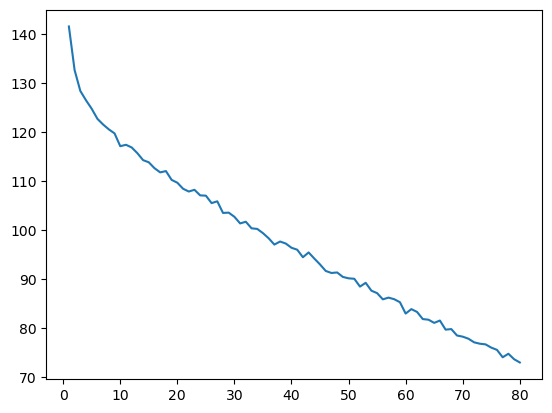

In [162]:
topic_model.elbow_plot() # going to use 50 clusters i.e. 50 topics

In [184]:
topic_model.create_topics(num_topics=50)

In [185]:
topic_model.topics_df.query("topic == 1")

,topic,topic_keywords,sentiment
"if youre looking for a flavour that will spark your taste buds, this is the place for you. the best thai find ive experienced yet. the taste isnt just strong but its unique. they make their own chilli oil which is so yummy and their bloody caesars are crafted with a house made spice rim and tom yom. very spicy! great environment, fun, loud hip hop\ old rap classics for playlist, but service could improve. server didnt introduce herself and the food took long, but overall, delicious!",1,"menu,spicy,beef,braised,thai",0.999545
"super jam-packed excitable lunch crowd on a sunny thursday afternoon. our table for 5 got in ten minutes before 12 and in a blink of an eye there was only bar-seating left and the basement volume was kickin.i ordered the shrimp pad thai and was fully satisfied that the noodles didnt stick to each other and the sauce was more sweet than savoury compared to what i expected from the dish.a fellow diner ordered the panang beef curry and i think i liked that dish even more than my own just from a little taste.dont come here for a quiet date, it aint the right mood for that sort of thing.",1,"menu,spicy,beef,braised,thai",0.987794
"first time here and the thai food is quite delicious and authentic! i had the beef noodle soup with the brisket. it was the perfect broth with fresh herbs. my sister had the green curry served in a coconut. we as a group had the fritters, beef salad and papaya salad as apps. the papaya salad was my favourite with the sauce to content mix. the atmosphere is rustic and warm. its on the lower level of a building. when we went around 5 we just missed the dinner rush. just an hr in, the restaurant is full and vibrant. the wait staff were super nice and helpful with the menu questions. another bonus is there was a phone charging station for your phone.",1,"menu,spicy,beef,braised,thai",0.999251
"before we even begin, let me tell you that this place is serious about its spice levels. mild is spicy. medium is very spicy. just our opinion. gringos be warned.when you walk down the steps to this place, you notice how many people inside are of asian descent. this is a good sign. the wait was about 20 minutes, and we amused ourselves watching people and checking the decor, as well as with the classic american rock music that was playing. there were records on the walls.the menu isnt long. the drink menu, i think, has more. we skipped the apps and starters and went straight for the meal. we had the same thing, which i cant recall the name of. it was on the top right of the main course menu, under the northern thai section.the sticky rice was great. the crispy pork was fantastic. the sauce was very tasty, even though it was very spicy. lots of flavors. we may go back to try something else while were here, which is about the highest compliment you can pay a place, right?update: we went back. wife had the curry with braised beef and i had the soup with beef broth. we dialed the spice down one notch each. it was fantastic. the wait was still there - theres never not one, it seems. we were seated in the chairless booth on mats. loved it. add half a star.",1,"menu,spicy,beef,braised,thai",0.996906


In [186]:
topic_model.topics_df.groupby(['topic', 'topic_keywords']).agg({'sentiment': 'mean'}).reset_index()\
    .sort_values(by='sentiment')

,topic,topic_keywords,sentiment
20,20,"rude,dishes,restaraunt,waiter,gratuity",-0.999092
46,46,"compared,flavours,san,shorter,khao",-0.998916
6,6,"serving,dish,dine,shrimp,thai",-0.998886
18,18,"management,stolen,camera,bag,cctv",-0.998695
34,34,"chang,drank,nikki,drinks,bae",-0.992813
49,49,"ordered,yum,soup,thai,noodles",-0.992336
45,45,"menu,khao,veggies,salad,lettuce",-0.791586
3,3,"dishes,noodles,curry,thai,khao",0.007827
48,48,"poulet,salted,thaïlande,thaï,thai",0.009057
12,12,"lemongrass,curries,thais,khao,thai",0.058784
